# <font style="color:blue">Faster RCNN Fine-tuning Experiment</font>

Již známe následující stavební blokové schéma Faster RCNN.

---
![](https://www.researchgate.net/profile/Giang_Son_Tran/publication/324549019/figure/fig1/AS:649929152266241@1531966593689/Faster-R-CNN-Architecture-9.png)

---

Chceme rychle doladit model Faster RCNN, aby fungoval pro náš detekční problém.
Poslední vrstva (klasifikátor) ve výše uvedeném obrázku bere zvětšené vlastnosti všech navrhovaných ohraničujících boxů a předpovídá třídy a ohraničující boxy. Pro tento úkol používá síť FastRCNNPredictor. Takže pro doladění s našimi daty musíme aktualizovat počet tříd v prediktoru.

Abychom získali model Faster RCNN s požadovaným počtem tříd, můžeme napsat následující metodu.

```python
def faster_rcnn_pretrained_model(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model
```

Začněme trénovat. Trainer použijeme k trénování a vyhodnocování našeho modelu. 


In [1]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_academy_my_work/refs/heads/main/work_module/trainer_faster_rcnn.zip" -O ./trainer.zip

!ls /kaggle/working/

!unzip /kaggle/working/trainer.zip

!rm /kaggle/working/trainer.zip

!cd ..

--2024-10-28 17:18:54--  https://raw.githubusercontent.com/RadimKozl/OpenCV_academy_my_work/refs/heads/main/work_module/trainer_faster_rcnn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12207 (12K) [application/zip]
Saving to: './trainer.zip'

./trainer.zip       100%[===================>]  11.92K  --.-KB/s    in 0s      

2024-10-28 17:18:54 (89.1 MB/s) - './trainer.zip' saved [12207/12207]

trainer.zip
Archive:  /kaggle/working/trainer.zip
   creating: trainer/.ipynb_checkpoints/
  inflating: trainer/.ipynb_checkpoints/configuration-checkpoint.py  
  inflating: trainer/__init__.py     
  inflating: trainer/base_metric.py  
  inflating: trainer/configuration.py  
  inflating: trainer/datasets.py     
  inflating: trainer/hooks.py        
  inflating: 

In [2]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_academy_my_work/refs/heads/main/work_module/faster_rcnn_detector.py" -O ./faster_rcnn_detector.py
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_academy_my_work/refs/heads/main/work_module/__init__.py" -O ./__init__.py

--2024-10-28 17:18:59--  https://raw.githubusercontent.com/RadimKozl/OpenCV_academy_my_work/refs/heads/main/work_module/faster_rcnn_detector.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 870 [text/plain]
Saving to: './faster_rcnn_detector.py'

./faster_rcnn_detec 100%[===================>]     870  --.-KB/s    in 0s      

2024-10-28 17:19:00 (84.5 MB/s) - './faster_rcnn_detector.py' saved [870/870]

--2024-10-28 17:19:01--  https://raw.githubusercontent.com/RadimKozl/OpenCV_academy_my_work/refs/heads/main/work_module/__init__.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HT

In [3]:
!mkdir data
!cp -r /kaggle/input/opencv-fruit-images-for-object-detection/test_zip /kaggle/working/data
!cp -r /kaggle/input/opencv-fruit-images-for-object-detection/train_zip /kaggle/working/data
!cp -r /kaggle/input/opencv-fruit-images-for-object-detection/labels_test.csv /kaggle/working/data
!cp -r /kaggle/input/opencv-fruit-images-for-object-detection/labels_train.csv /kaggle/working/data

In [4]:
!mkdir /kaggle/working/models/

# <font style="color:blue">Experiment (Trénink)</font>

Pojďme napsat třídu experimentu pro rychlé jemné doladění RCNN.

In [5]:
!pip install cubinlinker ptxcompiler cupy-cuda11x>=12.0.0
!pip install -U jupyterlab jupyterlab-lsp packaging scipy
!pip install -U tqdm 
!pip install -U ipython

ERROR: Could not find a version that satisfies the requirement cubinlinker (from versions: none)
ERROR: No matching distribution found for cubinlinker
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: jupyter-lsp
    Found existing installation: jupyter-lsp 1.5.1
    Uninstalling jupyter-lsp-1.5.1:
      Successfully uninstalled jupyter-lsp-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cu

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import random
import cv2

from operator import itemgetter

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from trainer import Trainer, hooks, configuration
from trainer.utils import patch_configs
from trainer.utils import setup_system

from trainer.metrics import APEstimator
from trainer.datasets import ListDataset
from trainer.matplotlib_visualizer import MatplotlibVisualizer
from trainer.utils import collate_fn

from faster_rcnn_detector import faster_rcnn_pretrained_model

import warnings
warnings.filterwarnings('ignore')

## <font style="color:green">1. Třída Experiment</font>

In [7]:
class Experiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = configuration.SystemConfig(),
        dataset_config: configuration.DatasetConfig = configuration.DatasetConfig(),  
        dataloader_config: configuration.DataloaderConfig = configuration.DataloaderConfig(),
        optimizer_config: configuration.OptimizerConfig = configuration.OptimizerConfig(),
    ):
        self.system_config = system_config
        setup_system(system_config)
        
        # fruit detection data has 3-classes. Anything other than these three classes is called background
        self.classes = ['__background__', 'apple', 'banana', 'orange']
        
        # written custom dataset class of our dataset
        train_csv_path = os.path.join(dataset_config.root_dir, 'labels_train.csv')
        self.dataset_train = ListDataset(
            csv_path=train_csv_path,
            train = True,
            transform=None
        )

        self.loader_train = DataLoader(
            dataset=self.dataset_train,
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,
            pin_memory=True
        )
        
        test_csv_path = os.path.join(dataset_config.root_dir, 'labels_test.csv')

        self.dataset_test = ListDataset(
            csv_path=test_csv_path,
            train=False,
            transform=None
        )
        self.loader_test = DataLoader(
            dataset=self.dataset_test,
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,
            pin_memory=True
        )
        
        # get faster rcnn model pretrained on coco
        self.model = faster_rcnn_pretrained_model(len(self.classes))
        
        self.metric_fn = APEstimator(classes=self.classes)
        
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optim.SGD(
            params,
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        self.visualizer = MatplotlibVisualizer()

    def run(self, trainer_config: configuration.TrainerConfig) -> dict:  
        setup_system(self.system_config)
        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("target"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mAP"),
            visualizer=self.visualizer,
            model_save_best=trainer_config.model_save_best,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir='/kaggle/working/models/'
        )

        model_trainer.register_hook("train", hooks.train_hook_faster_rcnn)
        model_trainer.register_hook("test", hooks.test_hook_faster_rcnn)
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_faster_rcnn)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def draw_bboxes(self, rows, columns, trainer_config: configuration.TrainerConfig):
        # load the best model
        if trainer_config.model_save_best:
            self.model.load_state_dict(
                torch.
                load(os.path.join('/kaggle/working/models', self.model.__class__.__name__) + '_best.pth')
            )
        # or use the last saved
        self.model = self.model.eval()

        fig, ax = plt.subplots(
            nrows=rows, ncols=columns, figsize=(15, 30), gridspec_kw={
                'wspace': 0,
                'hspace': 0.05
            }
        )
        
        colors = [(255, 0, 0), (0, 225, 0), (0, 0, 225)]

        for axi in ax.flat:
            index = random.randrange(len(self.loader_test.dataset))

            image, targets = self.loader_test.dataset[index]

            device = torch.device(trainer_config.device)
            image = image.to(device).clone()

            detections = self.model(image.unsqueeze(0))
            bboxes = detections[0]['boxes'].cpu().detach().numpy()
            labels = detections[0]['labels'].cpu().detach().numpy()
            scores = detections[0]['scores'].cpu().detach().numpy()

            with torch.no_grad():
                img = image.cpu()
                img = img.numpy().transpose(1, 2, 0)
                img = (img * 255.).astype(np.uint8)
                gt_img = img.copy()
                pred_img = img.copy()

                for i, box in enumerate(targets['boxes']):
                    label = targets['labels'][i]
                    cls = self.classes[label]
                    clr = colors[label-1]
                    gt_img = cv2.rectangle(
                        gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), clr, thickness=2)
                    gt_img = cv2.putText(gt_img, cls, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 
                                         0.9, clr, 2)
                    
                for i, box in enumerate(bboxes):
                    label = labels[i]
                    score = scores[i]
                    cls = self.classes[label]
                    clr = colors[label-1]
                    cls_score = '{0}:{1:.2}'.format(cls, score)
                    pred_img = cv2.rectangle(
                        pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), clr, thickness=2)
                    pred_img = cv2.putText(pred_img, cls_score, (int(box[0]), int(box[1])-10), 
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, clr, 2)

                merged_img = np.concatenate((gt_img, pred_img), axis=1)
                axi.imshow(merged_img)
                axi.axis('off')
        fig.show()

## <font style="color:green">2. Obrázky ovoce pro datovou sadu pro detekci objektů</font>

Zde jsme převzali datovou sadu pro detekci ovoce [Kaggle](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection). Má štítky ve formátu XML. Přidali jsme soubory štítků ve formátu CSV. Data si můžete stáhnout z **[tady](https://www.dropbox.com/sh/r2qxsaeq1otrtag/AAC1oI4g6n-upAB8M-VNYs68a?dl=1)**. 

Skládá se z `300` snímků (vlak `240` a testovací `60` ).

Má tři třídy – jablko, banán a pomeranč. 

Zde je jeden z příkladů dat, která datová sada poskytuje:

### [Stáhnout data](https://www.dropbox.com/sh/r2qxsaeq1otrtag/AAC1oI4g6n-upAB8M-VNYs68a?dl=1)
---

<img src='https://www.dropbox.com/s/837sdq5d1f2jxz3/apple_3.jpg?dl=1' align='middle'>

---


## <font style="color:green">3. Spustit Experiment</font>

/kaggle/working/data


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 198MB/s]  


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

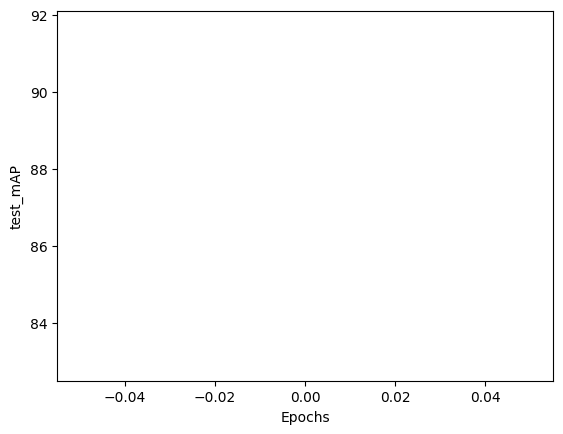

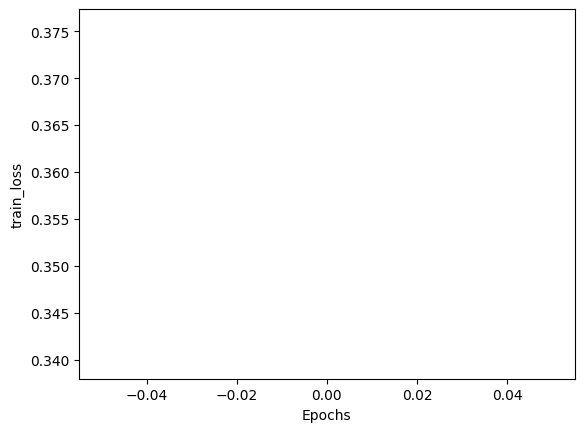

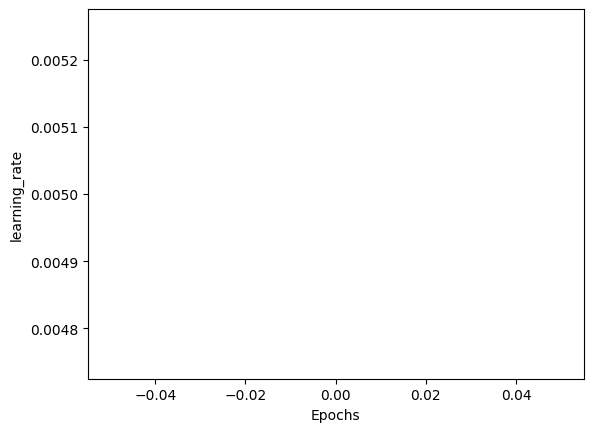

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
if __name__ == '__main__':
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=100, batch_size_to_set=2)
    
   
    

    dataset_config = configuration.DatasetConfig(root_dir=os.path.join('/','kaggle','working','data'))
    print(dataset_config.root_dir)
    
    
    optimizer_config = configuration.OptimizerConfig(
        learning_rate=5e-3, 
        lr_step_milestones=[50], 
        lr_gamma=0.1, 
        momentum=0.9, 
        weight_decay=1e-5
    )
    
    experiment = Experiment(
        dataset_config=dataset_config, 
        dataloader_config=dataloader_config, 
        optimizer_config=optimizer_config
    )
    
    # Run the experiment / start training
    experiment.run(trainer_config)

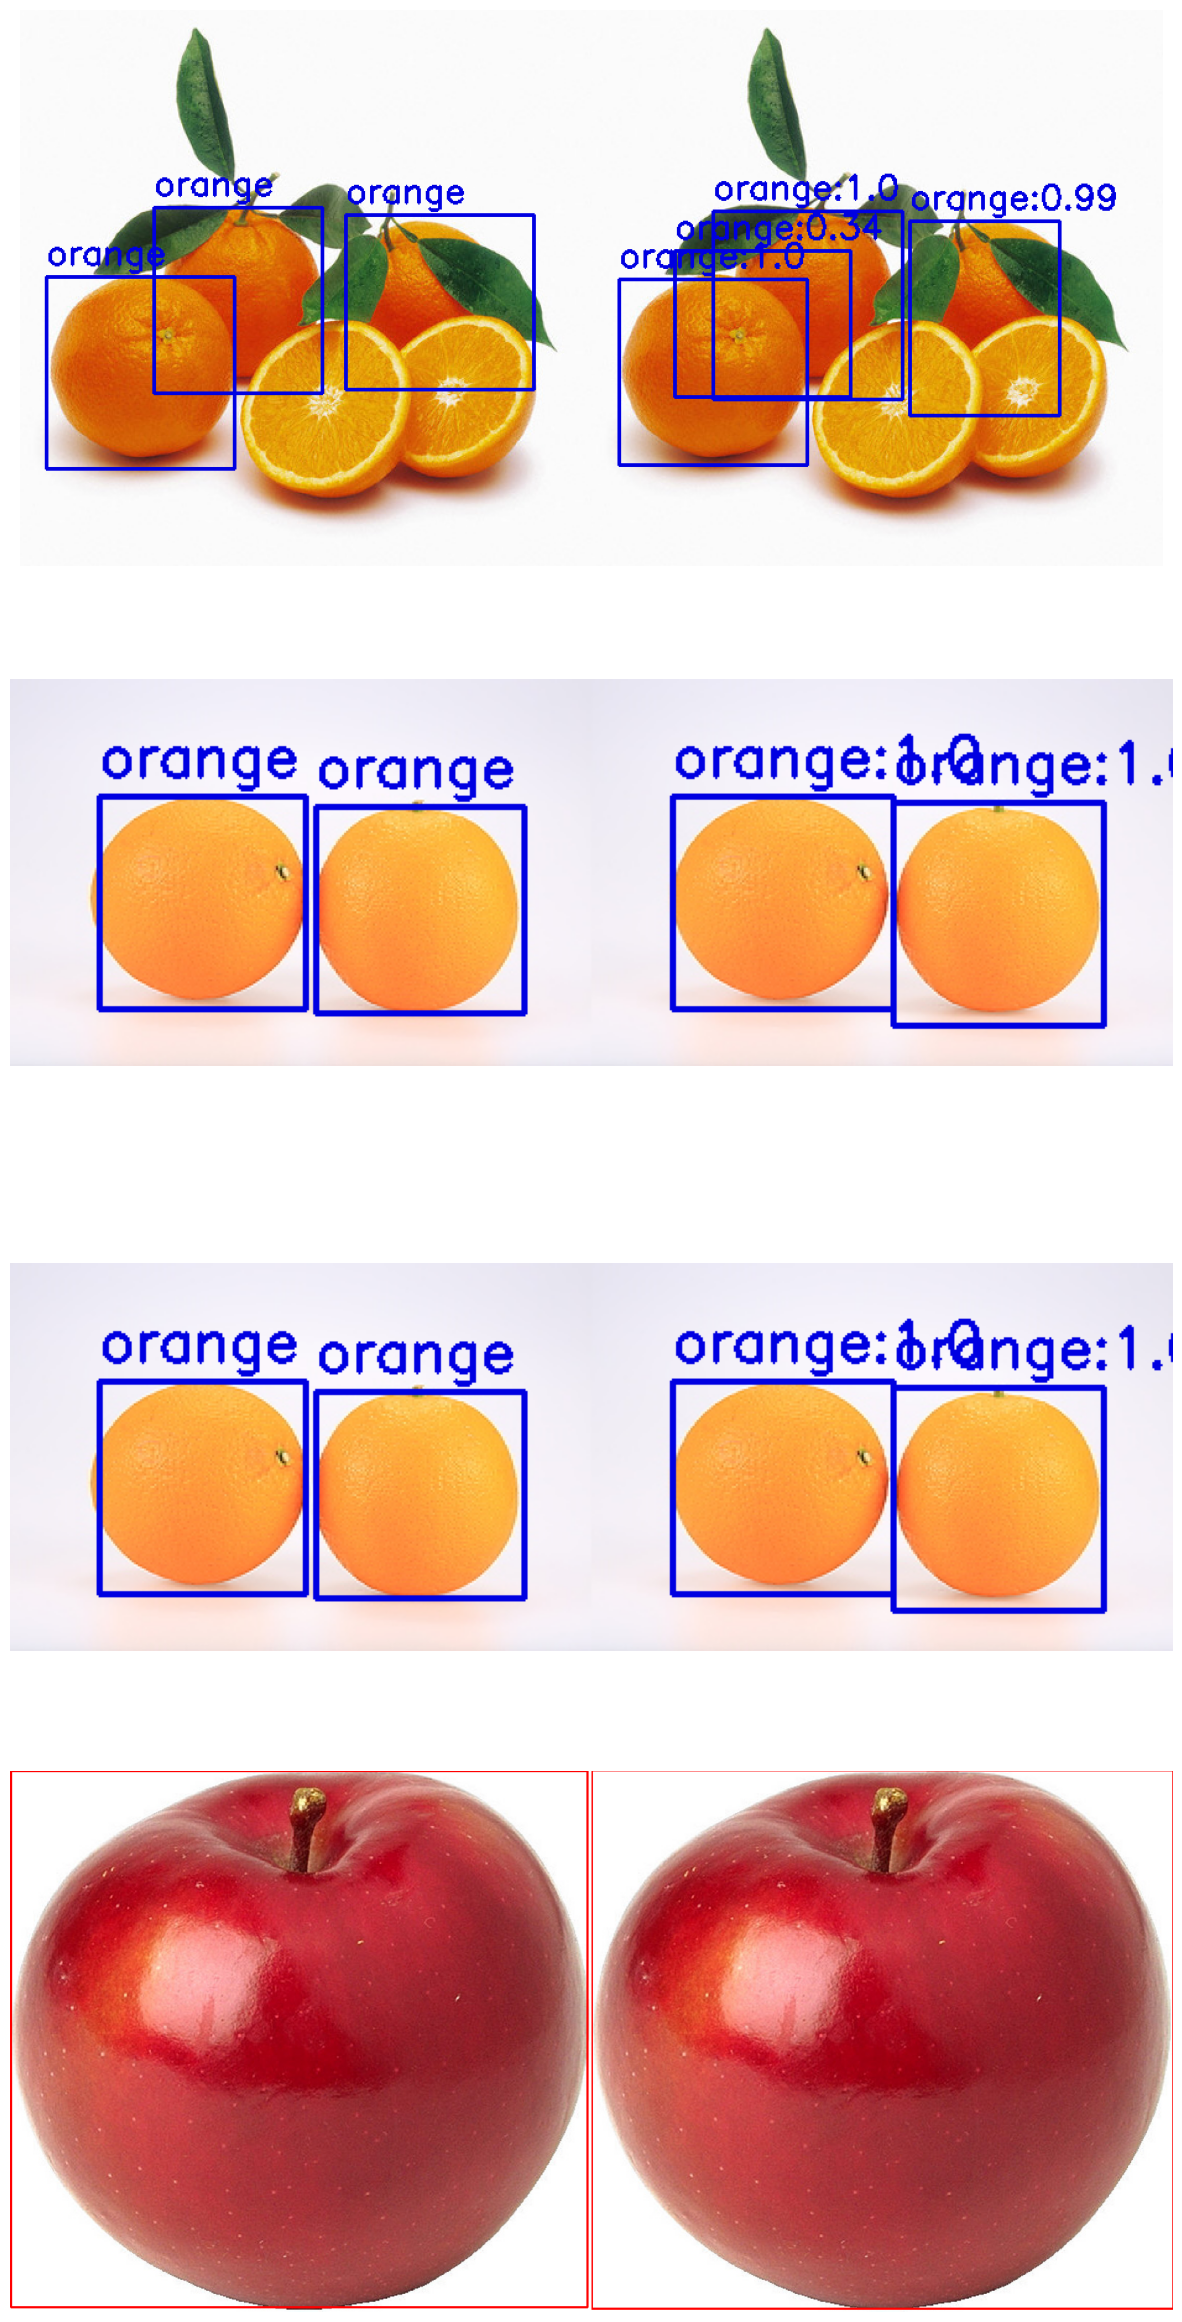

In [9]:
# how good our detector works by visualizing the results on the randomly chosen test images:

if __name__ == '__main__':
    experiment.draw_bboxes(4, 1, trainer_config)

## <font style="color:green">4. Zkuste to s jinou datovou sadou</font>

Vylaďte model Faster-RCNN pro své vlastní nebo veřejně dostupné datové sady. Následuje několik odkazů na veřejně dostupné datové sady:

- [MCIndoor20000](https://github.com/bircatmcri/MCIndoor20000)

- [The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)

- [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

- [KITTI Vision](http://www.cvlibs.net/datasets/kitti/)


In [10]:
!zip -r /kaggle/working/models.zip /kaggle/working/models/

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/FasterRCNN_best.pth (deflated 7%)


In [11]:
!rm -rf /kaggle/working/data

**Used dataset from Kaggle**

[OpenCV - Fruit Images for Object Detection](https://www.kaggle.com/datasets/radimkzl/opencv-fruit-images-for-object-detection)